# NLP CS683 — Distilbert Implementation over OLID Dataset





In [ ]:
# Core imports & environment checks
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import torch

from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (
    classification_report,

    confusion_matrix,
    ConfusionMatrixDisplay,
)

from transformers import (
    AutoTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)


print('Environment check:')
print('Python:', os.sys.version.splitlines()[0])
print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available(), 'Device count:', torch.cuda.device_count())
if torch.cuda.is_available():
    try:
        print('Device name:', torch.cuda.get_device_name(0))
    except Exception:
        pass

OUT_DIR = 'D:/IIIT-G/SEM-3/NLP/PROJECt/RESULTS'
os.makedirs(OUT_DIR, exist_ok=True)
print('OUT_DIR:', OUT_DIR)

c:\Users\Nishant\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Environment check:
Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
Torch: 2.5.1
CUDA available: True Device count: 1
Device name: NVIDIA GeForce RTX 4050 Laptop GPU
OUT_DIR: D:/IIIT-G/SEM-3/NLP/PROJECt/RESULTS


DATASET LOADING AND PREPROCESSING

In [2]:
# Load OLID dataset from the exact path you requested
olid_path = 'D:/IIIT-G/SEM-3/NLP/PROJECT/olid-training-v1.0.tsv'
if not os.path.exists(olid_path):
    raise FileNotFoundError(f"OLID dataset not found at {olid_path}. Add the dataset to the notebook via 'Add data' and ensure the path is exactly /kaggle/input/olid-dataset/olid-training-v1.0.tsv")

print('Loading OLID from:', olid_path)
df = pd.read_csv(olid_path, sep='\t', encoding='utf-8', quoting=3)
print('Loaded shape:', df.shape)
print('Columns:', df.columns.tolist())
df.head()

Loading OLID from: D:/IIIT-G/SEM-3/NLP/PROJECT/olid-training-v1.0.tsv
Loaded shape: (13240, 5)
Columns: ['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c']


,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"""@USER Someone should'veTaken"""" this piece of ...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [3]:
# Inspect subtask columns
for col in ['subtask_a','subtask_b','subtask_c']:
    if col in df.columns:
        print('\nValue counts for', col)
        print(df[col].value_counts(dropna=False).head(50))


Value counts for subtask_a
subtask_a
NOT    8840
OFF    4400
Name: count, dtype: int64

Value counts for subtask_b
subtask_b
NaN    8840
TIN    3876
UNT     524
Name: count, dtype: int64

Value counts for subtask_c
subtask_c
NaN    9364
IND    2407
GRP    1074
OTH     395
Name: count, dtype: int64


In [4]:
# Text cleaning (vectorized)
assert 'tweet' in df.columns, "Column 'tweet' not found in dataset."
df['clean_text'] = (
    df['tweet'].astype(str)
      .str.replace(r'http\S+|www\.\S+', '', regex=True)
      .str.replace(r'@\w+', '', regex=True)
      .str.replace(r'#', '', regex=True)
      .str.replace(r'[^a-zA-Z\s]', ' ', regex=True)
      .str.replace(r'\s+', ' ', regex=True)
      .str.strip()
      .str.lower()
)
df[['tweet','clean_text']].head(6)

,tweet,clean_text
0,@USER She should ask a few native Americans wh...,she should ask a few native americans what the...
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you re drunk maga trump url
2,Amazon is investigating Chinese employees who ...,amazon is investigating chinese employees who ...
3,"""@USER Someone should'veTaken"""" this piece of ...",someone should vetaken this piece of shit to a...
4,@USER @USER Obama wanted liberals &amp; illega...,obama wanted liberals amp illegals to move int...
5,@USER Liberals are all Kookoo !!!,liberals are all kookoo


IMPORTANT FUNCTIONS:

1. df_to_hf_inmemory():

The df_to_hf_inmemory() function is designed to take lists of raw text samples and their corresponding labels, and transform them into a format that can be directly used by Hugging Face’s training pipeline. It first creates a small pandas DataFrame containing the text and label columns, then uses the tokenizer to process all the text data in batches. Each sentence is tokenized into input IDs, padded or truncated to a maximum length of 128 tokens, and then formatted into PyTorch tensors. The function finally returns a Dataset object that is compatible with the Trainer class, making it easy to feed into the model for training or evaluation. In simple terms, this function prepares the textual data so that DistilBERT can learn from it efficiently.

2. generate_classification_report():

The generate_classification_report() function is used after training the model to evaluate how well it performs on unseen test data. It runs the trained model (through the trainer object) on an evaluation dataset and collects the predicted outputs. These predictions are compared with the true labels to generate a confusion matrix, which shows how many samples were correctly or incorrectly classified for each class. It also prints a detailed classification report that includes precision, recall, F1-score, and overall accuracy. To help visualize the results, the function plots the confusion matrix as a heatmap and saves the plot in the output directory. Essentially, this function helps you interpret your model’s performance both numerically and visually.

3. make_balanced_hf_datasets():

The make_balanced_hf_datasets() function deals with the issue of class imbalance, which is common in real-world datasets where one class has many more examples than the others. To fix this, the function identifies the class with the highest number of samples and then duplicates (upsamples) the examples from smaller classes so that all classes have an equal number of samples. After balancing, it shuffles the dataset for randomness and converts both the balanced training set and the original test set into Hugging Face datasets using the df_to_hf_inmemory function. By doing so, it ensures that the model learns equally well from all classes rather than being biased toward the majority class.

4. train_distilbert(): 

The train_distilbert() function creates and configures the DistilBERT model for fine-tuning. It loads the pre-trained DistilBERT model for sequence classification and sets key training parameters such as the number of epochs, batch size, learning rate, and gradient accumulation steps. It also enables mixed-precision training (FP16) when a GPU is available, allowing for faster and more memory-efficient computation. The function automatically creates output and logging directories based on the training stage number (for example, results_stage-1 for Stage 1) to organize the experiment outputs neatly. Once everything is configured, it returns a Trainer object, which acts as a complete training controller. You can simply call .train() on it to start training the model.

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

def df_to_hf_inmemory(texts, labels):
     
    df_tmp = pd.DataFrame({'text': list(texts), 'labels': list(labels)})
    ds = Dataset.from_pandas(df_tmp)
    ds = ds.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=128), batched=True)
    ds.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
    return ds


def generate_classification_report(trainer, eval_dataset, label_names=None, show_plot=True, save_plot=True, digits=4):

    pred_output = trainer.predict(eval_dataset)
    logits = pred_output.predictions
    labels = pred_output.label_ids
    if logits is None:
        raise RuntimeError("No predictions found in trainer.predict(...) output.")
    if logits.ndim == 2:
        preds = np.argmax(logits, axis=1)
    else:
        preds = (logits > 0.5).astype(int).ravel()
    cm = confusion_matrix(labels, preds)
    print("Confusion matrix (counts):\n", cm)
    if label_names is None:
        try:
            id2label = trainer.model.config.id2label
            label_names = [id2label[i] for i in sorted(id2label.keys())]
        except Exception:
            n_classes = cm.shape[0]
            label_names = [f"CLASS_{i}" for i in range(n_classes)]
    if len(label_names) != cm.shape[0]:
        if len(label_names) > cm.shape[0]:
            label_names = label_names[:cm.shape[0]]
        else:
            label_names = label_names + [f"CLASS_{i}" for i in range(len(label_names), cm.shape[0])]
    report_str = classification_report(labels, preds, target_names=label_names, digits=digits)
    print("\nClassification report:\n")
    print(report_str)
    fig, ax = plt.subplots(figsize=(7,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
    ax.set_title("Confusion Matrix (counts)")
    plt.tight_layout()
    if save_plot:
        os.makedirs(OUT_DIR, exist_ok=True)
        out_path = os.path.join(OUT_DIR, "confusion_matrix.png")
        fig.savefig(out_path, bbox_inches='tight')
        print(f"Saved confusion matrix to: {out_path}")
    if show_plot:
        plt.show()




def make_balanced_hf_datasets(X_train, y_train, X_test, y_test, df_to_hf_func=df_to_hf_inmemory, random_state=42):
   
    train_df = pd.DataFrame({'text': list(X_train), 'label': list(y_train)})
    max_size = train_df['label'].value_counts().max()

    balanced_train_df = pd.concat([
        resample(group, replace=True, n_samples=max_size, random_state=random_state)
        for _, group in train_df.groupby('label')
    ], ignore_index=True)

    balanced_train_df = balanced_train_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    X_train_bal = balanced_train_df['text']
    y_train_bal = balanced_train_df['label']

    train_ds = df_to_hf_func(X_train_bal, y_train_bal)
    test_ds = df_to_hf_func(X_test, y_test)

    print("Balanced training set class counts:")
    print(y_train_bal.value_counts())

    return train_ds, test_ds




def train_distilbert(train_ds, test_ds, number_of_labels, stage_number ):

    model_name = "distilbert-base-uncased"
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=number_of_labels)

    num_train_epochs = 15
    per_device_train_batch_size = 16
    per_device_eval_batch_size = 16
    gradient_accumulation_steps = 2
    learning_rate = 1e-4

    fp16 = True if torch.cuda.is_available() else False
    out_dir = OUT_DIR  
    tokenizer_obj = tokenizer  

    training_args = TrainingArguments(
        output_dir=os.path.join(out_dir, f"results_stage-{stage_number}"),
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="no",
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        logging_dir=os.path.join(out_dir,f"logs_stage-{stage_number}"),
        load_best_model_at_end=False,
        fp16=fp16,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer_obj
    )

    return trainer




c:\Users\Nishant\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


STAGE-1: OFF vs NOT CLASSIFICATION

In [10]:
#DATA PREPROCESSING AND LOADING FOR STAGE-1


label_map_a = {'NOT':0, 'OFF':1}
if 'subtask_a' not in df.columns:
    raise KeyError("Column 'subtask_a' missing — verify OLID dataset version.")

df_a = df[df['subtask_a'].isin(label_map_a.keys())].copy()
df_a['y_a'] = df_a['subtask_a'].map(label_map_a)
print('Stage1 samples:', df_a.shape[0])
print(df_a['y_a'].value_counts())



X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    df_a['clean_text'], df_a['y_a'], test_size=0.2, random_state=42, stratify=df_a['y_a']
)
print('Stage1 -> Train:', len(X_train_a), 'Test:', len(X_test_a))


print("Sample text:", X_train_a[1])
print("Label:", y_train_a[1])

print("Shape of training data: ", X_train_a.shape )
print("Shape of test data: ", X_test_a.shape )


Stage1 samples: 13240
y_a
0    8840
1    4400
Name: count, dtype: int64
Stage1 -> Train: 10592 Test: 2648
Sample text: go home you re drunk maga trump url
Label: 1
Shape of training data:  (10592,)
Shape of test data:  (2648,)


In [12]:
# DistilBERT Stage1 setup 


print('Transformers version:', __import__('transformers').__version__)

train_ds_a,test_ds_a = make_balanced_hf_datasets(X_train_a, y_train_a, X_test_a, y_test_a)

trainer_a = train_distilbert(train_ds_a, test_ds_a, 2,1 )

trainer_a.train()

Transformers version: 4.40.2


Map: 100%|██████████| 2648/2648 [00:00<00:00, 10735.77 examples/s]
c:\Users\Nishant\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Balanced training set class counts:
label
1    7072
0    7072
Name: count, dtype: int64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 221/2210 [00:58<07:47,  4.26it/s]

{'loss': 0.4486, 'grad_norm': 3.121546745300293, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.0}


                                                  
 10%|█         | 221/2210 [01:01<07:47,  4.26it/s]

{'eval_loss': 0.49659106135368347, 'eval_runtime': 2.7084, 'eval_samples_per_second': 977.714, 'eval_steps_per_second': 61.292, 'epoch': 1.0}


 20%|██        | 442/2210 [01:53<06:56,  4.24it/s]

{'loss': 0.2337, 'grad_norm': 8.240653991699219, 'learning_rate': 2.4013574660633487e-05, 'epoch': 2.0}


                                                  
 20%|██        | 442/2210 [01:55<06:56,  4.24it/s]

{'eval_loss': 0.6146807074546814, 'eval_runtime': 2.7076, 'eval_samples_per_second': 977.974, 'eval_steps_per_second': 61.308, 'epoch': 2.0}


 30%|███       | 663/2210 [02:47<06:03,  4.25it/s]

{'loss': 0.1204, 'grad_norm': 2.312049388885498, 'learning_rate': 2.1013574660633485e-05, 'epoch': 3.0}


                                                  
 30%|███       | 663/2210 [02:50<06:03,  4.25it/s]

{'eval_loss': 0.8210798501968384, 'eval_runtime': 2.7021, 'eval_samples_per_second': 979.981, 'eval_steps_per_second': 61.434, 'epoch': 3.0}


 40%|████      | 884/2210 [03:42<05:11,  4.26it/s]

{'loss': 0.0724, 'grad_norm': 0.9957897663116455, 'learning_rate': 1.802714932126697e-05, 'epoch': 4.0}


                                                  
 40%|████      | 884/2210 [03:45<05:11,  4.26it/s]

{'eval_loss': 0.9932768940925598, 'eval_runtime': 2.6991, 'eval_samples_per_second': 981.067, 'eval_steps_per_second': 61.502, 'epoch': 4.0}


 50%|█████     | 1105/2210 [04:37<04:20,  4.23it/s]

{'loss': 0.0468, 'grad_norm': 0.43607306480407715, 'learning_rate': 1.5027149321266969e-05, 'epoch': 5.0}


                                                   
 50%|█████     | 1105/2210 [04:40<04:20,  4.23it/s]

{'eval_loss': 1.0488955974578857, 'eval_runtime': 2.7569, 'eval_samples_per_second': 960.495, 'eval_steps_per_second': 60.212, 'epoch': 5.0}


 60%|██████    | 1326/2210 [05:32<03:28,  4.23it/s]

{'loss': 0.0328, 'grad_norm': 0.15622082352638245, 'learning_rate': 1.2027149321266969e-05, 'epoch': 6.0}


                                                   
 60%|██████    | 1326/2210 [05:35<03:28,  4.23it/s]

{'eval_loss': 1.1466175317764282, 'eval_runtime': 2.773, 'eval_samples_per_second': 954.909, 'eval_steps_per_second': 59.862, 'epoch': 6.0}


 70%|███████   | 1547/2210 [06:27<02:36,  4.22it/s]

{'loss': 0.0219, 'grad_norm': 0.056714944541454315, 'learning_rate': 9.027149321266969e-06, 'epoch': 7.0}


                                                   
 70%|███████   | 1547/2210 [06:30<02:36,  4.22it/s]

{'eval_loss': 1.3600884675979614, 'eval_runtime': 2.7611, 'eval_samples_per_second': 959.038, 'eval_steps_per_second': 60.121, 'epoch': 7.0}


 80%|████████  | 1768/2210 [07:22<01:44,  4.24it/s]

{'loss': 0.0166, 'grad_norm': 0.124754898250103, 'learning_rate': 6.027149321266969e-06, 'epoch': 8.0}


                                                   
 80%|████████  | 1768/2210 [07:25<01:44,  4.24it/s]

{'eval_loss': 1.3428505659103394, 'eval_runtime': 2.7568, 'eval_samples_per_second': 960.52, 'eval_steps_per_second': 60.214, 'epoch': 8.0}


 90%|█████████ | 1989/2210 [08:18<00:52,  4.22it/s]

{'loss': 0.0095, 'grad_norm': 1.4884434938430786, 'learning_rate': 3.0271493212669686e-06, 'epoch': 9.0}


                                                   
 90%|█████████ | 1989/2210 [08:20<00:52,  4.22it/s]

{'eval_loss': 1.3705440759658813, 'eval_runtime': 2.7694, 'eval_samples_per_second': 956.176, 'eval_steps_per_second': 59.942, 'epoch': 9.0}


100%|██████████| 2210/2210 [09:13<00:00,  4.24it/s]

{'loss': 0.0072, 'grad_norm': 0.040241919457912445, 'learning_rate': 2.7149321266968328e-08, 'epoch': 10.0}


                                                   
100%|██████████| 2210/2210 [09:15<00:00,  3.97it/s]

{'eval_loss': 1.4193283319473267, 'eval_runtime': 2.7788, 'eval_samples_per_second': 952.946, 'eval_steps_per_second': 59.739, 'epoch': 10.0}
{'train_runtime': 556.008, 'train_samples_per_second': 254.385, 'train_steps_per_second': 3.975, 'train_loss': 0.10098577619138346, 'epoch': 10.0}


TrainOutput(global_step=2210, training_loss=0.10098577619138346, metrics={'train_runtime': 556.008, 'train_samples_per_second': 254.385, 'train_steps_per_second': 3.975, 'total_flos': 4684047216476160.0, 'train_loss': 0.10098577619138346, 'epoch': 10.0})

100%|██████████| 166/166 [00:02<00:00, 57.91it/s]


Confusion matrix (counts):
 [[1416  352]
 [ 248  632]]

Classification report:

              precision    recall  f1-score   support

         NOT     0.8510    0.8009    0.8252      1768
         OFF     0.6423    0.7182    0.6781       880

    accuracy                         0.7734      2648
   macro avg     0.7466    0.7595    0.7516      2648
weighted avg     0.7816    0.7734    0.7763      2648

Saved confusion matrix to: D:/IIIT-G/SEM-3/NLP/PROJECt/RESULTS\confusion_matrix.png


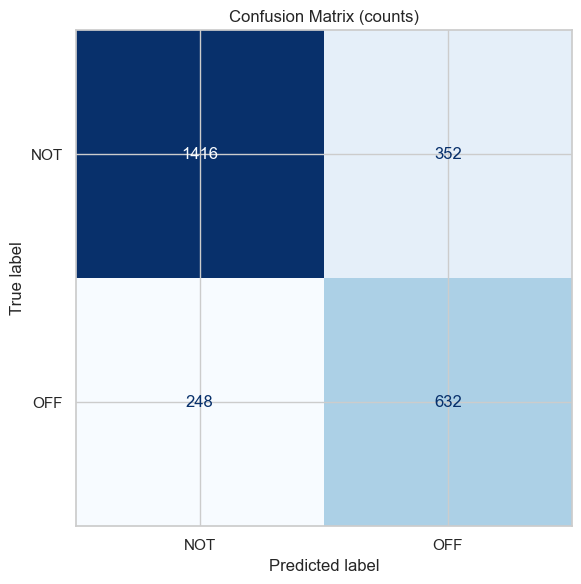

In [13]:
generate_classification_report(trainer_a, test_ds_a, label_names=['NOT','OFF'])

In [14]:
trainer_a.save_model(os.path.join(OUT_DIR, "distilbert_stage1_final"))
tokenizer.save_pretrained(os.path.join(OUT_DIR, "distilbert_stage1_final"))
print("✅ Stage 1 model saved at:", os.path.join(OUT_DIR, "distilbert_stage1_final"))


✅ Stage 1 model saved at: D:/IIIT-G/SEM-3/NLP/PROJECt/RESULTS\distilbert_stage1_final


STAGE-2 (A) : UNTARGETED VS TARGET INDIVIDUAL

Stage2A samples: 4400
y_b
1    3876
0     524
Name: count, dtype: int64
Stage2A -> Train: 3520 Test: 880


Map: 100%|██████████| 880/880 [00:00<00:00, 26946.63 examples/s]
c:\Users\Nishant\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Balanced training set class counts:
label
1    3101
0    3101
Name: count, dtype: int64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 194/2910 [00:26<05:50,  7.74it/s]

{'loss': 0.3538, 'grad_norm': 3.9824721813201904, 'learning_rate': 9.336769759450172e-05, 'epoch': 1.0}



  7%|▋         | 195/2910 [00:27<18:11,  2.49it/s]

{'eval_loss': 0.5842117071151733, 'eval_runtime': 0.8927, 'eval_samples_per_second': 985.762, 'eval_steps_per_second': 61.61, 'epoch': 1.0}


 13%|█▎        | 388/2910 [00:52<05:24,  7.76it/s]

{'loss': 0.0514, 'grad_norm': 0.030438533052802086, 'learning_rate': 8.673539518900344e-05, 'epoch': 2.0}



 13%|█▎        | 389/2910 [00:54<16:59,  2.47it/s]

{'eval_loss': 0.8808435797691345, 'eval_runtime': 0.8999, 'eval_samples_per_second': 977.885, 'eval_steps_per_second': 61.118, 'epoch': 2.0}


 20%|██        | 582/2910 [01:19<05:02,  7.71it/s]

{'loss': 0.0301, 'grad_norm': 0.16032011806964874, 'learning_rate': 8.006872852233678e-05, 'epoch': 3.0}



 20%|██        | 583/2910 [01:20<15:38,  2.48it/s]

{'eval_loss': 1.0753051042556763, 'eval_runtime': 0.8988, 'eval_samples_per_second': 979.113, 'eval_steps_per_second': 61.195, 'epoch': 3.0}


 27%|██▋       | 776/2910 [01:47<04:37,  7.69it/s]

{'loss': 0.0137, 'grad_norm': 0.10542353242635727, 'learning_rate': 7.34020618556701e-05, 'epoch': 4.0}



 27%|██▋       | 777/2910 [01:48<14:55,  2.38it/s]

{'eval_loss': 1.193424105644226, 'eval_runtime': 0.9503, 'eval_samples_per_second': 925.979, 'eval_steps_per_second': 57.874, 'epoch': 4.0}


 33%|███▎      | 970/2910 [02:14<04:09,  7.77it/s]

{'loss': 0.0087, 'grad_norm': 0.0028642555698752403, 'learning_rate': 6.673539518900343e-05, 'epoch': 5.0}



 33%|███▎      | 971/2910 [02:15<12:58,  2.49it/s]

{'eval_loss': 1.358115315437317, 'eval_runtime': 0.8923, 'eval_samples_per_second': 986.252, 'eval_steps_per_second': 61.641, 'epoch': 5.0}


 40%|████      | 1164/2910 [02:40<03:45,  7.75it/s]

{'loss': 0.0175, 'grad_norm': 0.01135560218244791, 'learning_rate': 6.010309278350515e-05, 'epoch': 6.0}



 40%|████      | 1165/2910 [02:41<11:41,  2.49it/s]

{'eval_loss': 1.1025439500808716, 'eval_runtime': 0.892, 'eval_samples_per_second': 986.588, 'eval_steps_per_second': 61.662, 'epoch': 6.0}


 47%|████▋     | 1358/2910 [03:07<03:20,  7.75it/s]

{'loss': 0.0109, 'grad_norm': 0.011039406061172485, 'learning_rate': 5.343642611683849e-05, 'epoch': 7.0}



 47%|████▋     | 1359/2910 [03:08<10:26,  2.47it/s]

{'eval_loss': 1.1872010231018066, 'eval_runtime': 0.8985, 'eval_samples_per_second': 979.361, 'eval_steps_per_second': 61.21, 'epoch': 7.0}


 53%|█████▎    | 1552/2910 [03:34<02:55,  7.76it/s]

{'loss': 0.0079, 'grad_norm': 0.000868207192979753, 'learning_rate': 4.676975945017182e-05, 'epoch': 8.0}



 53%|█████▎    | 1553/2910 [03:35<09:05,  2.49it/s]

{'eval_loss': 1.2821458578109741, 'eval_runtime': 0.8922, 'eval_samples_per_second': 986.331, 'eval_steps_per_second': 61.646, 'epoch': 8.0}


 60%|██████    | 1746/2910 [04:01<02:30,  7.74it/s]

{'loss': 0.0056, 'grad_norm': 0.0006137834279797971, 'learning_rate': 4.010309278350516e-05, 'epoch': 9.0}



 60%|██████    | 1747/2910 [04:02<07:46,  2.49it/s]

{'eval_loss': 1.4297230243682861, 'eval_runtime': 0.8903, 'eval_samples_per_second': 988.483, 'eval_steps_per_second': 61.78, 'epoch': 9.0}


 67%|██████▋   | 1940/2910 [04:28<02:05,  7.75it/s]

{'loss': 0.0054, 'grad_norm': 0.13974221050739288, 'learning_rate': 3.3436426116838486e-05, 'epoch': 10.0}



 67%|██████▋   | 1941/2910 [04:29<06:28,  2.50it/s]

{'eval_loss': 1.3708014488220215, 'eval_runtime': 0.8872, 'eval_samples_per_second': 991.937, 'eval_steps_per_second': 61.996, 'epoch': 10.0}


 73%|███████▎  | 2134/2910 [04:55<01:39,  7.79it/s]

{'loss': 0.005, 'grad_norm': 0.0004921335494145751, 'learning_rate': 2.676975945017182e-05, 'epoch': 11.0}



 73%|███████▎  | 2135/2910 [04:56<05:12,  2.48it/s]

{'eval_loss': 1.4482090473175049, 'eval_runtime': 0.8943, 'eval_samples_per_second': 984.015, 'eval_steps_per_second': 61.501, 'epoch': 11.0}


 80%|████████  | 2328/2910 [05:22<01:14,  7.84it/s]

{'loss': 0.0036, 'grad_norm': 0.10441186279058456, 'learning_rate': 2.0103092783505157e-05, 'epoch': 12.0}



 80%|████████  | 2329/2910 [05:23<03:53,  2.49it/s]

{'eval_loss': 1.4770030975341797, 'eval_runtime': 0.8972, 'eval_samples_per_second': 980.874, 'eval_steps_per_second': 61.305, 'epoch': 12.0}


 87%|████████▋ | 2522/2910 [05:49<00:50,  7.75it/s]

{'loss': 0.0035, 'grad_norm': 0.0004322447348386049, 'learning_rate': 1.3436426116838488e-05, 'epoch': 13.0}



 87%|████████▋ | 2523/2910 [05:50<02:41,  2.40it/s]

{'eval_loss': 1.4885318279266357, 'eval_runtime': 0.9376, 'eval_samples_per_second': 938.591, 'eval_steps_per_second': 58.662, 'epoch': 13.0}


 93%|█████████▎| 2716/2910 [06:16<00:24,  7.78it/s]

{'loss': 0.0035, 'grad_norm': 0.09177768975496292, 'learning_rate': 6.7697594501718215e-06, 'epoch': 14.0}



 93%|█████████▎| 2717/2910 [06:17<01:18,  2.46it/s]

{'eval_loss': 1.5001134872436523, 'eval_runtime': 0.9028, 'eval_samples_per_second': 974.761, 'eval_steps_per_second': 60.923, 'epoch': 14.0}


100%|██████████| 2910/2910 [06:43<00:00,  7.71it/s]

{'loss': 0.0035, 'grad_norm': 0.0003380199195817113, 'learning_rate': 1.0309278350515465e-07, 'epoch': 15.0}



100%|██████████| 2910/2910 [06:44<00:00,  7.19it/s]


{'eval_loss': 1.5142314434051514, 'eval_runtime': 0.9009, 'eval_samples_per_second': 976.808, 'eval_steps_per_second': 61.051, 'epoch': 15.0}
{'train_runtime': 404.4671, 'train_samples_per_second': 230.006, 'train_steps_per_second': 7.195, 'train_loss': 0.03494309004639432, 'epoch': 15.0}


100%|██████████| 55/55 [00:00<00:00, 60.47it/s]


Confusion matrix (counts):
 [[ 13  92]
 [ 47 728]]

Classification report:

              precision    recall  f1-score   support

         UNT     0.2167    0.1238    0.1576       105
         TIN     0.8878    0.9394    0.9129       775

    accuracy                         0.8420       880
   macro avg     0.5522    0.5316    0.5352       880
weighted avg     0.8077    0.8420    0.8227       880

Saved confusion matrix to: D:/IIIT-G/SEM-3/NLP/PROJECt/RESULTS\confusion_matrix.png


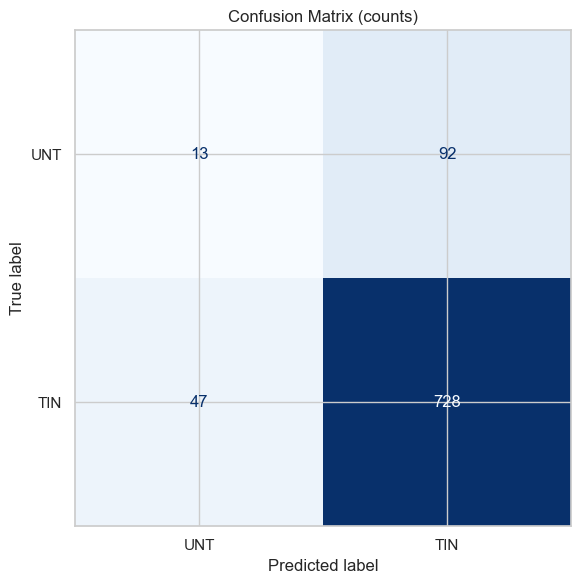

✅ Stage2A baseline model saved successfully!


In [10]:
# Stage 2A (UNT vs TIN)

label_map_b = {'UNT':0, 'TIN':1}
if 'subtask_b' not in df.columns:
    print("Warning: 'subtask_b' not found — skipping Stage2A")
else:
    df_b = df[df['subtask_b'].isin(label_map_b.keys())].copy()
    df_b['y_b'] = df_b['subtask_b'].map(label_map_b)
    print('Stage2A samples:', df_b.shape[0])
    print(df_b['y_b'].value_counts())

    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
        df_b['clean_text'], df_b['y_b'], test_size=0.2, random_state=42, stratify=df_b['y_b']
    )
    print('Stage2A -> Train:', len(X_train_b), 'Test:', len(X_test_b))

    train_ds_b,test_ds_b = make_balanced_hf_datasets(X_train_b, y_train_b, X_test_b, y_test_b)

    trainer_b = train_distilbert(train_ds_b, test_ds_b, 2,21 )

    trainer_b.train()

    generate_classification_report(trainer_b, test_ds_b, label_names=['UNT','TIN'])

# Save trained model + tokenizer
trainer_b.save_model("stage2A_baseline")
tokenizer.save_pretrained("stage2A_baseline")

print("✅ Stage2A baseline model saved successfully!")



STAGE-2B : INDIVIDUAL VS GROUP VS OTHERS

Stage2B samples: 3876
subtask_c
IND    2407
GRP    1074
OTH     395
Name: count, dtype: int64
Stage2B -> Train: 3100 Test: 776
✅ Ready Stage2B trainer (call trainer_c.train() to train)


Map: 100%|██████████| 776/776 [00:00<00:00, 20731.21 examples/s]
c:\Users\Nishant\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Balanced training set class counts:
label
2    1925
0    1925
1    1925
Name: count, dtype: int64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  7%|▋         | 180/2700 [00:24<05:37,  7.47it/s]

{'loss': 0.6918, 'grad_norm': 3.9982964992523193, 'learning_rate': 9.337037037037037e-05, 'epoch': 1.0}



  7%|▋         | 182/2700 [00:25<12:36,  3.33it/s]

{'eval_loss': 0.8898539543151855, 'eval_runtime': 0.7835, 'eval_samples_per_second': 990.478, 'eval_steps_per_second': 62.543, 'epoch': 1.0}


 13%|█▎        | 361/2700 [00:49<05:10,  7.53it/s]

{'loss': 0.1847, 'grad_norm': 12.030295372009277, 'learning_rate': 8.67037037037037e-05, 'epoch': 2.0}



 13%|█▎        | 362/2700 [00:49<14:31,  2.68it/s]

{'eval_loss': 1.1606920957565308, 'eval_runtime': 0.7885, 'eval_samples_per_second': 984.094, 'eval_steps_per_second': 62.14, 'epoch': 2.0}


 20%|██        | 541/2700 [01:14<04:49,  7.47it/s]

{'loss': 0.1005, 'grad_norm': 6.696497917175293, 'learning_rate': 8.003703703703704e-05, 'epoch': 3.0}



 20%|██        | 543/2700 [01:15<10:48,  3.33it/s]

{'eval_loss': 1.3773025274276733, 'eval_runtime': 0.7909, 'eval_samples_per_second': 981.126, 'eval_steps_per_second': 61.953, 'epoch': 3.0}


 27%|██▋       | 722/2700 [01:39<04:22,  7.53it/s]

{'loss': 0.039, 'grad_norm': 0.23825448751449585, 'learning_rate': 7.333333333333333e-05, 'epoch': 4.0}



 27%|██▋       | 723/2700 [01:39<12:15,  2.69it/s]

{'eval_loss': 1.8020973205566406, 'eval_runtime': 0.7846, 'eval_samples_per_second': 989.018, 'eval_steps_per_second': 62.451, 'epoch': 4.0}


 33%|███▎      | 902/2700 [02:03<04:01,  7.45it/s]

{'loss': 0.0227, 'grad_norm': 0.041303601115942, 'learning_rate': 6.666666666666667e-05, 'epoch': 5.0}



 33%|███▎      | 904/2700 [02:04<09:00,  3.32it/s]

{'eval_loss': 2.111584186553955, 'eval_runtime': 0.785, 'eval_samples_per_second': 988.485, 'eval_steps_per_second': 62.417, 'epoch': 5.0}


 40%|████      | 1083/2700 [02:28<03:34,  7.55it/s]

{'loss': 0.0165, 'grad_norm': 0.00475552212446928, 'learning_rate': 5.996296296296296e-05, 'epoch': 6.0}



 40%|████      | 1084/2700 [02:29<10:01,  2.69it/s]

{'eval_loss': 2.2731401920318604, 'eval_runtime': 0.7833, 'eval_samples_per_second': 990.727, 'eval_steps_per_second': 62.559, 'epoch': 6.0}


 47%|████▋     | 1263/2700 [02:53<03:12,  7.45it/s]

{'loss': 0.0046, 'grad_norm': 0.00203178939409554, 'learning_rate': 5.32962962962963e-05, 'epoch': 7.0}



 47%|████▋     | 1264/2700 [02:54<08:53,  2.69it/s]

{'eval_loss': 2.5611355304718018, 'eval_runtime': 0.7902, 'eval_samples_per_second': 982.085, 'eval_steps_per_second': 62.013, 'epoch': 7.0}


 53%|█████▎    | 1444/2700 [03:18<02:46,  7.56it/s]

{'loss': 0.0045, 'grad_norm': 0.0054640863090753555, 'learning_rate': 4.6592592592592595e-05, 'epoch': 8.0}



 54%|█████▎    | 1445/2700 [03:19<07:48,  2.68it/s]

{'eval_loss': 2.385634660720825, 'eval_runtime': 0.7874, 'eval_samples_per_second': 985.561, 'eval_steps_per_second': 62.233, 'epoch': 8.0}


 60%|██████    | 1624/2700 [03:43<02:24,  7.44it/s]

{'loss': 0.0029, 'grad_norm': 0.576957643032074, 'learning_rate': 3.9925925925925926e-05, 'epoch': 9.0}



 60%|██████    | 1625/2700 [03:44<06:41,  2.68it/s]

{'eval_loss': 2.392340660095215, 'eval_runtime': 0.7878, 'eval_samples_per_second': 985.032, 'eval_steps_per_second': 62.199, 'epoch': 9.0}


 67%|██████▋   | 1805/2700 [04:08<01:59,  7.50it/s]

{'loss': 0.0028, 'grad_norm': 0.0028281891718506813, 'learning_rate': 3.322222222222222e-05, 'epoch': 10.0}



 67%|██████▋   | 1806/2700 [04:09<05:32,  2.69it/s]

{'eval_loss': 2.889997720718384, 'eval_runtime': 0.7856, 'eval_samples_per_second': 987.834, 'eval_steps_per_second': 62.376, 'epoch': 10.0}


 74%|███████▎  | 1985/2700 [04:33<01:35,  7.51it/s]

{'loss': 0.0012, 'grad_norm': 0.0011626762570813298, 'learning_rate': 2.6555555555555555e-05, 'epoch': 11.0}



 74%|███████▎  | 1987/2700 [04:34<03:36,  3.30it/s]

{'eval_loss': 2.744694232940674, 'eval_runtime': 0.7971, 'eval_samples_per_second': 973.573, 'eval_steps_per_second': 61.476, 'epoch': 11.0}


 80%|████████  | 2166/2700 [04:59<01:10,  7.53it/s]

{'loss': 0.0002, 'grad_norm': 0.0011017213109880686, 'learning_rate': 1.985185185185185e-05, 'epoch': 12.0}



 80%|████████  | 2167/2700 [04:59<03:19,  2.67it/s]

{'eval_loss': 2.705554485321045, 'eval_runtime': 0.7874, 'eval_samples_per_second': 985.488, 'eval_steps_per_second': 62.228, 'epoch': 12.0}


 87%|████████▋ | 2346/2700 [05:24<00:47,  7.43it/s]

{'loss': 0.0001, 'grad_norm': 0.0008960461127571762, 'learning_rate': 1.3185185185185186e-05, 'epoch': 13.0}



 87%|████████▋ | 2348/2700 [05:25<01:45,  3.33it/s]

{'eval_loss': 2.6696481704711914, 'eval_runtime': 0.7875, 'eval_samples_per_second': 985.399, 'eval_steps_per_second': 62.222, 'epoch': 13.0}


 94%|█████████▎| 2527/2700 [05:49<00:23,  7.49it/s]

{'loss': 0.0005, 'grad_norm': 0.0013304363237693906, 'learning_rate': 6.518518518518518e-06, 'epoch': 14.0}



 94%|█████████▎| 2528/2700 [05:49<01:05,  2.64it/s]

{'eval_loss': 2.7472012042999268, 'eval_runtime': 0.8054, 'eval_samples_per_second': 963.444, 'eval_steps_per_second': 60.836, 'epoch': 14.0}


100%|██████████| 2700/2700 [06:13<00:00,  7.41it/s]

{'loss': 0.0001, 'grad_norm': 0.000991127802990377, 'learning_rate': 1.1111111111111112e-07, 'epoch': 14.96}



100%|██████████| 2700/2700 [06:13<00:00,  7.22it/s]


{'eval_loss': 2.7676329612731934, 'eval_runtime': 0.7941, 'eval_samples_per_second': 977.261, 'eval_steps_per_second': 61.709, 'epoch': 14.96}
{'train_runtime': 373.9347, 'train_samples_per_second': 231.658, 'train_steps_per_second': 7.221, 'train_loss': 0.07155779737427279, 'epoch': 14.96}


100%|██████████| 49/49 [00:00<00:00, 61.29it/s]


Confusion matrix (counts):
 [[375  85  22]
 [ 46 153  16]
 [ 28  38  13]]

Classification report:

              precision    recall  f1-score   support

         IND     0.8352    0.7780    0.8056       482
         GRP     0.5543    0.7116    0.6232       215
         OTH     0.2549    0.1646    0.2000        79

    accuracy                         0.6972       776
   macro avg     0.5481    0.5514    0.5429       776
weighted avg     0.6983    0.6972    0.6934       776

Saved confusion matrix to: D:/IIIT-G/SEM-3/NLP/PROJECt/RESULTS\confusion_matrix.png


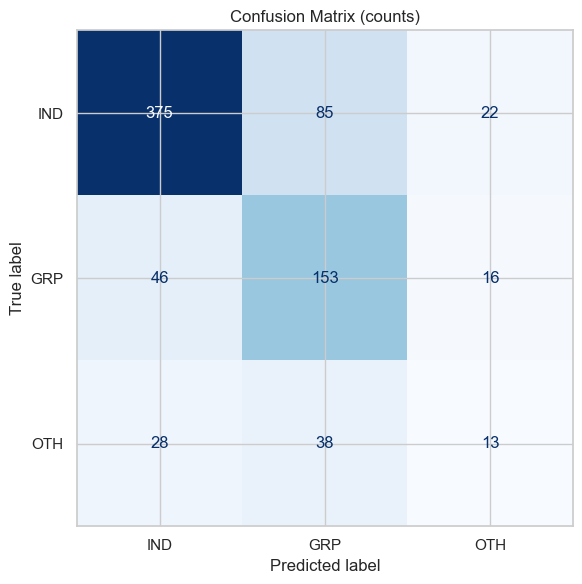

In [9]:
# Stage 2B (IND vs GRP vs OTH)
label_map_c = {'IND':0, 'GRP':1, 'OTH':2}
if 'subtask_c' not in df.columns:
    print("Warning: 'subtask_c' not found — skipping Stage2B")
else:
    df_c = df[df['subtask_c'].isin(label_map_c.keys())].copy()
    df_c['y_c'] = df_c['subtask_c'].map(label_map_c)
    print('Stage2B samples:', df_c.shape[0])
    print(df_c['subtask_c'].value_counts())

    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        df_c['clean_text'], df_c['y_c'], test_size=0.2, random_state=42, stratify=df_c['y_c']
    )
    print('Stage2B -> Train:', len(X_train_c), 'Test:', len(X_test_c))

   
    print('✅ Ready Stage2B trainer (call trainer_c.train() to train)')

    train_ds_c,test_ds_c = make_balanced_hf_datasets(X_train_c, y_train_c, X_test_c, y_test_c)

    trainer_c = train_distilbert(train_ds_c, test_ds_c, 3,22 )

    trainer_c.train()

    generate_classification_report(trainer_c, test_ds_c, label_names= ['IND', 'GRP', 'OTH'])





In [ ]:
SAVE_PATH_C = os.path.join(OUT_DIR, "stage2B_balanced_model")
trainer_c.save_model(SAVE_PATH_C)
print(f"✅ Model saved at: {SAVE_PATH_C}")



✅ Model saved at: D:/IIIT-G/SEM-3/NLP/PROJECt/RESULTS\stage2B_balanced_model
